GoingDeep 2
=====

Practical 2
---

The aim of this practical is to learn simple data curation practices, and familiarize you with some of the data we'll be reusing later.

In this example, we'll explore learning with Caffe in Python, using the fully-exposed `Solver` interface with the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. This dataset let us start to introduce more tricky blocks, such as convolutional layer.

### 1. Setup

* Python usual setup with `numpy`, and `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# display the plot inline in this notebook
%matplotlib inline

# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import os
import sys
import gzip
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import lmdb
import shutil
import tempfile

import pandas as pd

# Visualize net
from google.protobuf import text_format
from caffe.draw import get_pydot_graph
from caffe.proto import caffe_pb2
from IPython.display import display, Image 


* Import `caffe`, adding it to `sys.path` if needed. Make sure you've built pycaffe.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import os
import sys

caffe_root = '/opt/caffe/'  # this file should be run from {caffe_root}/examples (otherwise change this line)
cd = os.getcwd()
#sys.path.insert(0, caffe_root + 'python')

import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### 2. Load the dataset

* We'll be using the provided LeNet example data and networks (make sure you've downloaded the data and created the databases, as below). The MNIST database has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size 28x28  image (10 classes). 

In [3]:
dirname = os.path.abspath('./mnist/data')
if not os.path.exists(dirname):
    os.makedirs(dirname)
    
# run scripts from caffe root
os.chdir(caffe_root)
# Download data
!data/mnist/get_mnist.sh

# Prepare data
!examples/mnist/create_mnist.sh
!cp -r examples/mnist/mnist_t* /media/met/Dati/Met/Dropbox/Uni/dottorato/RemoteLab/GoingDeep/mnist/data

os.chdir(cd)

Downloading...
Creating lmdb...
I1210 16:12:16.623509  8573 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_train_lmdb
I1210 16:12:16.623623  8573 convert_mnist_data.cpp:88] A total of 60000 items.
I1210 16:12:16.623628  8573 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1210 16:12:21.362630  8573 convert_mnist_data.cpp:108] Processed 60000 files.
I1210 16:12:21.410434  8576 db_lmdb.cpp:35] Opened lmdb examples/mnist/mnist_test_lmdb
I1210 16:12:21.410547  8576 convert_mnist_data.cpp:88] A total of 10000 items.
I1210 16:12:21.410552  8576 convert_mnist_data.cpp:89] Rows: 28 Cols: 28
I1210 16:12:22.221464  8576 convert_mnist_data.cpp:108] Processed 10000 files.
Done.


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a 
number 0 through 0. Display a sample of the images that we just downloaded. Hint: you can directly use the package 
matplotlib after you read the image.

---

Labels: [7, 2, 1, 0, 4]


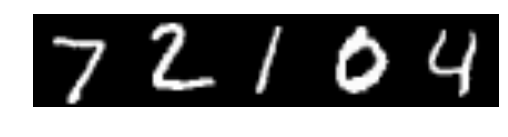

In [3]:
lmdb_file = 'mnist/data/mnist_test_lmdb/'
lmdb_env = lmdb.open(lmdb_file)
lmdb_txn = lmdb_env.begin()
lmdb_cursor = lmdb_txn.cursor()
datum = caffe_pb2.Datum()
image_size = 28
images =  np.ndarray(shape=(lmdb_env.stat()['entries'], image_size, image_size))
labels = []
i = 0
for key, value in lmdb_cursor:
    datum.ParseFromString(value)

    label = datum.label
    data = caffe.io.datum_to_array(datum)
    im = data.astype(np.uint8).reshape(image_size,image_size)
    
    images[i, :, :] = im
    labels.append(label)
    i += 1

print "Labels: " + str(labels[:5])
plt.imshow(images[:5,:,:].transpose(1, 0, 2).reshape(image_size, image_size*5), cmap=plt.cm.gray)
plt.axis('off')
plt.show()


---
Problem 2
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

(array([  980.,  1135.,  1032.,  1010.,   982.,   892.,   958.,  1028.,
          974.,  1009.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

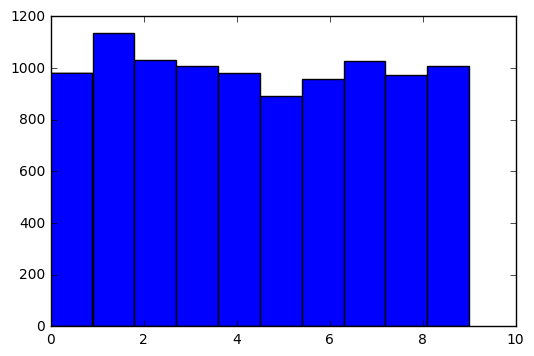

In [4]:
plt.hist(labels,bins=10)

---
Problem 3
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use all you have learn in the previous practical

Optional question: train an off-the-shelf model on all the data!

---

Creating the net 
====

Now let's make a variant of LeNet, the classic 1989 convnet architecture.

We'll need two external files to help out:
* the net `prototxt`, defining the architecture and pointing to the train/test data
* the solver `prototxt`, defining the learning parameters

We start by creating the net. We'll write the net in a succinct and natural way as Python code that serializes to Caffe's protobuf model format.

This network expects to read from pregenerated LMDBs, but reading directly from `ndarray`s is also possible using `MemoryDataLayer`.

In [5]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

train_net_path = "mnist/lenet_auto_train.prototxt"
test_net_path = "mnist/lenet_auto_test.prototxt"
    
with open(train_net_path, 'w') as f:
    f.write(str(lenet('mnist/data/mnist_train_lmdb', 64)))
    
with open(test_net_path, 'w') as f:
    f.write(str(lenet('mnist/data/mnist_test_lmdb', 100)))

Now let's see the learning parameters, which are also written as a `prototxt` file (already provided on disk). We're using SGD with momentum, weight decay, and a specific learning rate schedule.

In [6]:
from caffe.proto import caffe_pb2

class create_solver(object):
    def __init__(self, train_net_path, test_net_path):
        self.train_net_path = train_net_path
        self.test_net_path = test_net_path
        
        self.define_solver()
    
    def define_solver(self):
        self.s = caffe_pb2.SolverParameter()

        # Specify locations of the train and test networks.
        self.s.train_net = self.train_net_path
        self.s.test_net.append(self.test_net_path)

        self.s.test_interval = 100  # Test after every 100 training iterations.
        self.s.test_iter.append(250) # Test 250 "batches" each time we test.

        self.s.max_iter = 10000      # # of times to update the net (training iterations)

        # Set the initial learning rate for stochastic gradient descent (SGD).
        self.s.base_lr = 0.01        
        # Set `lr_policy` to define how the learning rate changes during training.
        # Return the current learning rate. The currently implemented learning rate
        # policies are as follows:
        # - fixed: always return base_lr.
        # - step: return base_lr * gamma ^ (floor(iter / step))
        # - exp: return base_lr * gamma ^ iter
        #  inv: return base_lr * (1 + gamma * iter) ^ (- power)
        # - multistep: similar to step but it allows non uniform steps defined by
        # stepvalue
        # - poly: the effective learning rate follows a polynomial decay, to be
        #  zero by the max_iter. return base_lr (1 - iter/max_iter) ^ (power)
        # - sigmoid: the effective learning rate follows a sigmod decay
        # return base_lr ( 1/(1 + exp(-gamma * (iter - stepsize))))
        #
        # where base_lr, max_iter, gamma, step, stepvalue and power are defined
        # in the solver parameter protocol buffer, and iter is the current iteration
        self.s.lr_policy = 'inv'
        self.s.gamma = 0.0001
        self.s.power = 0.75

        # Set other optimization parameters. Setting a non-zero `momentum` takes a
        # weighted average of the current gradient and previous gradients to make
        # learning more stable. L2 weight decay regularizes learning, to help prevent
        # the model from overfitting.
        self.s.momentum = 0.9
        self.s.weight_decay = 5e-4

        # Display the current training loss and accuracy every 1000 iterations.
        self.s.display = 100

        # Snapshots are files used to store networks we've trained.  Here, we'll
        # snapshot every 10K iterations -- just once at the end of training.
        # For larger networks that take longer to train, you may want to set
        # snapshot < max_iter to save the network and training state to disk during
        # optimization, preventing disaster in case of machine crashes, etc.
        self.s.snapshot = 10000
        self.s.snapshot_prefix = 'mnist/'

        # We'll train on the CPU for fair benchmarking against scikit-learn.
        # Changing to GPU should result in much faster training!
        self.s.solver_mode = caffe_pb2.SolverParameter.CPU

        return self.s

    def write_solver(self, solver_path):
        with open(solver_path, 'w') as f:
            f.write(str(self.s))
        
solver_path = 'mnist/lenet_auto_solver.prototxt'
s = create_solver(train_net_path, test_net_path)       
s.write_solver(solver_path)

### 3. Loading and checking the solver

* Let's pick a device and load the solver. We'll use SGD (with momentum), but other methods (such as Adagrad and Nesterov's accelerated gradient) are also available.

In [7]:
caffe.set_mode_cpu()

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.SGDSolver('mnist/lenet_auto_solver.prototxt')

* To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

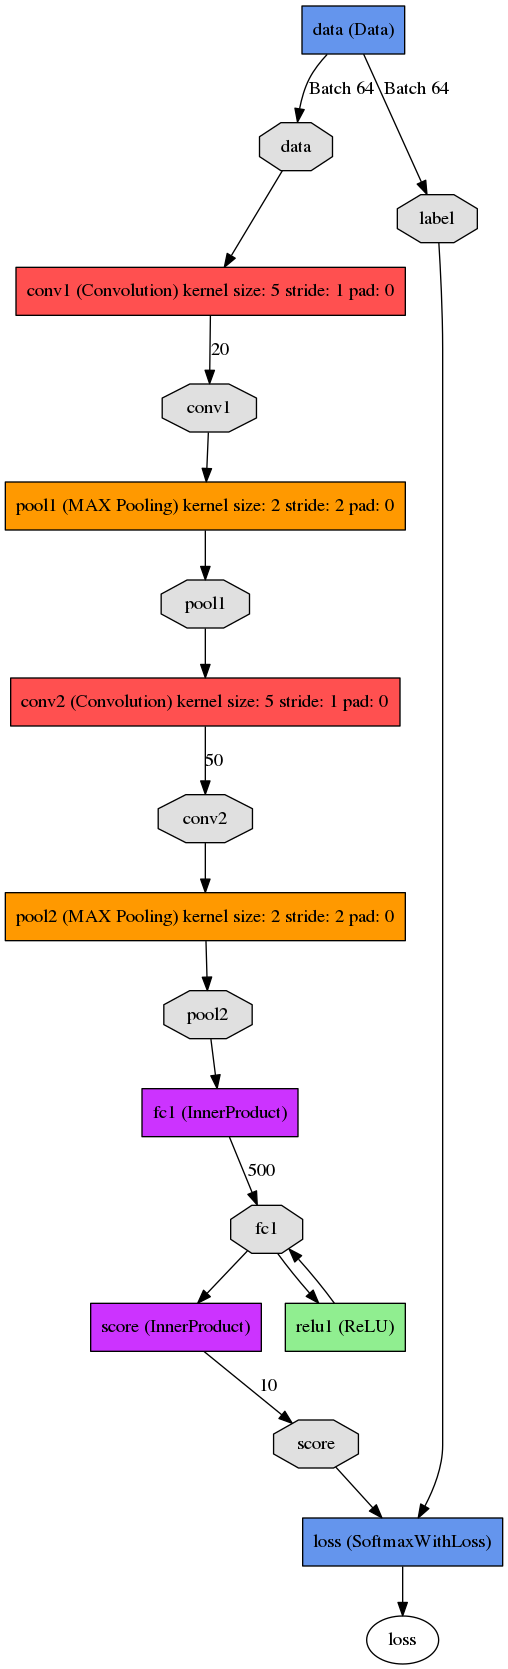

In [8]:
def view_graph(prototxt):
    _net = caffe_pb2.NetParameter()
    f = open(prototxt)
    text_format.Merge(f.read(), _net)
    display(Image(get_pydot_graph(_net,"TB").create_png()))
    
view_graph("mnist/lenet_auto_train.prototxt")

In [9]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (64, 1, 28, 28)),
 ('label', (64,)),
 ('conv1', (64, 20, 24, 24)),
 ('pool1', (64, 20, 12, 12)),
 ('conv2', (64, 50, 8, 8)),
 ('pool2', (64, 50, 4, 4)),
 ('fc1', (64, 500)),
 ('score', (64, 10)),
 ('loss', ())]

In [10]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1', (20, 1, 5, 5)),
 ('conv2', (50, 20, 5, 5)),
 ('fc1', (500, 800)),
 ('score', (10, 500))]

---
Problem 4
---------

How many parameteres there are in this network?

---

In [11]:
total = np.sum([np.prod(v[0].data.shape) for k, v in solver.net.params.items()])
print "Total number of parameters: " + str(total)

Total number of parameters: 430500


* Before taking off, let's check that everything is loaded as we expect. We'll run a forward pass on the train and test nets and check that they contain our data.

In [12]:
solver.net.forward()  # train net
solver.test_nets[0].forward()  # test net (there can be more than one)

{'loss': array(2.3116137981414795, dtype=float32)}

train labels: [ 5.  0.  4.  1.  9.  2.  1.  3.]


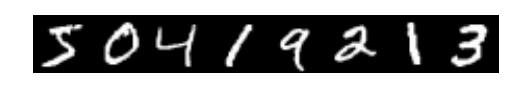

In [13]:
# we use a little trick to tile the first eight images
plt.imshow(solver.net.blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); plt.axis('off')
print 'train labels:', solver.net.blobs['label'].data[:8]

test labels: [ 7.  2.  1.  0.  4.  1.  4.  9.]


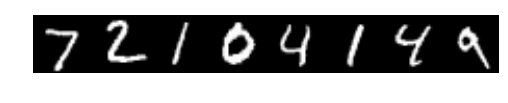

In [14]:
plt.imshow(solver.test_nets[0].blobs['data'].data[:8, 0].transpose(1, 0, 2).reshape(28, 8*28), cmap='gray'); plt.axis('off')
print 'test labels:', solver.test_nets[0].blobs['label'].data[:8]

### 4. Stepping the solver

Both train and test nets seem to be loading data, and to have correct labels.

* Let's take one step of (minibatch) SGD and see what happens.

In [15]:
solver.step(1)

Do we have gradients propagating through our filters? Let's see the updates to the first layer, shown here as a $4 \times 5$ grid of $5 \times 5$ filters.

(-0.5, 24.5, 19.5, -0.5)

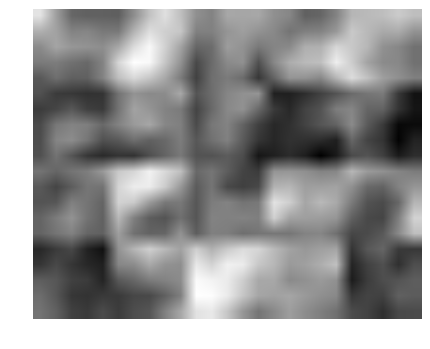

In [16]:
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); plt.axis('off')

### 5. Writing a custom training loop

Something is happening. Let's run the net for a while, keeping track of a few things as it goes.
Note that this process will be the same as if training through the `caffe` binary. In particular:
* logging will continue to happen as normal
* snapshots will be taken at the interval specified in the solver prototxt (here, every 5000 iterations)
* testing will happen at the interval specified (here, every 500 iterations)

Since we have control of the loop in Python, we're free to compute additional things as we go, as we show below. We can do many other things as well, for example:
* write a custom stopping criterion
* change the solving process by updating the net in the loop

In [65]:
#%%time
niter = 700
test_interval = 100
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))
output = np.zeros((niter, 8, 10))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
    solver.test_nets[0].forward(start='conv1')
    output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

Iteration 0 testing...
Iteration 100 testing...
Iteration 200 testing...
Iteration 300 testing...
Iteration 400 testing...
Iteration 500 testing...
Iteration 600 testing...
Iteration 700 testing...


IndexError: index 7 is out of bounds for axis 0 with size 7

* Let's plot the train loss and test accuracy.

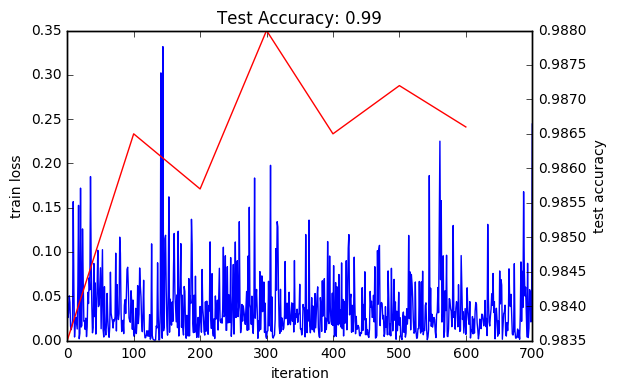

In [66]:
_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))

The loss seems to have dropped quickly and coverged (except for stochasticity), while the accuracy rose correspondingly. Hooray!

* Since we saved the results on the first test batch, we can watch how our prediction scores evolved. We'll plot time on the $x$ axis and each possible label on the $y$, with lightness indicating confidence.

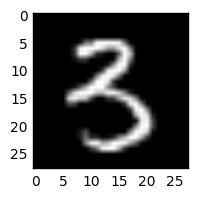

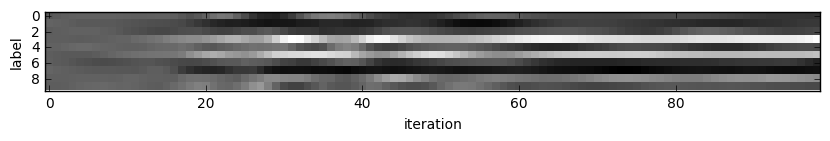

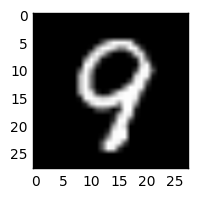

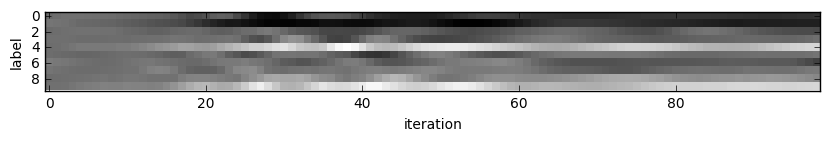

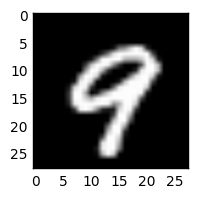

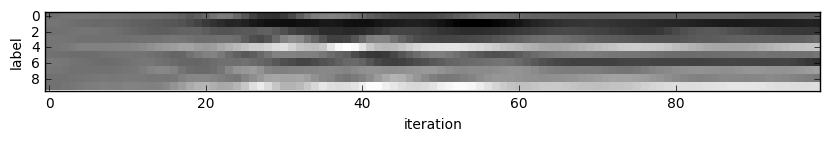

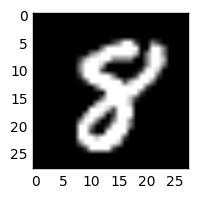

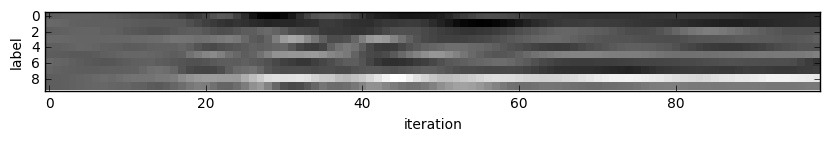

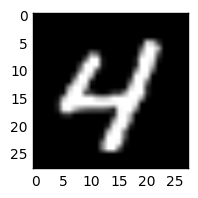

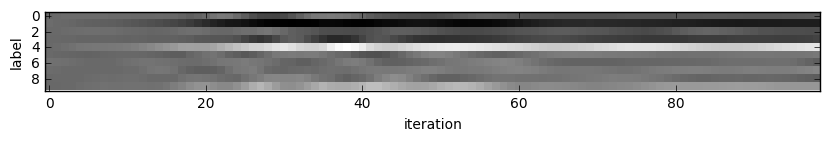

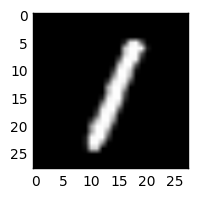

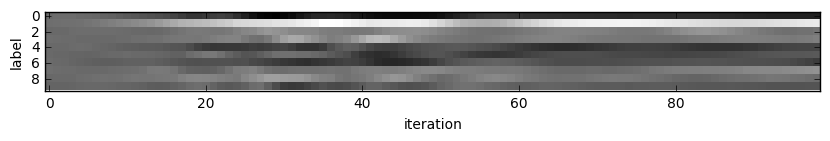

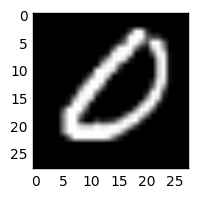

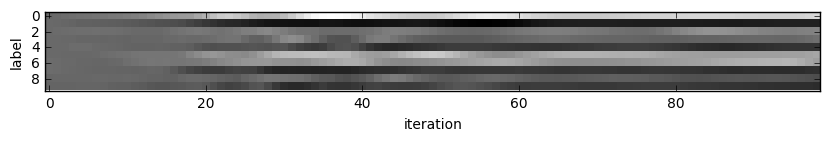

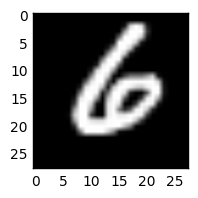

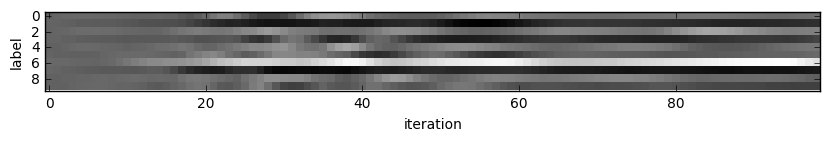

In [19]:
for i in range(8):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.figure(figsize=(10, 2))
    plt.imshow(output[:99, i].T, interpolation='nearest', cmap='gray')
    plt.xlabel('iteration')
    plt.ylabel('label')

We started with little idea about any of these digits, and ended up with correct classifications for each. If you've been following along, you'll see the last digit is the most difficult, a slanted "9" that's (understandably) most confused with "4".

* Note that these are the "raw" output scores rather than the softmax-computed probability vectors. The latter, shown below, make it easier to see the confidence of our net (but harder to see the scores for less likely digits).

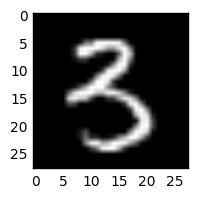

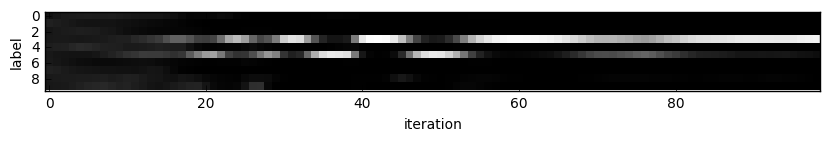

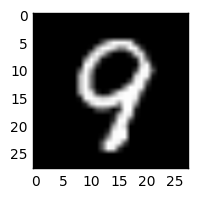

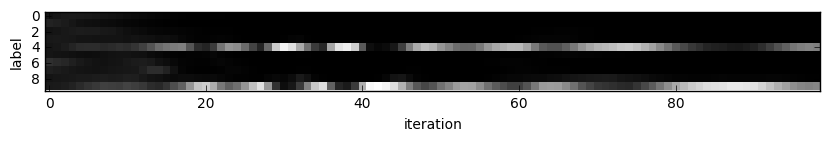

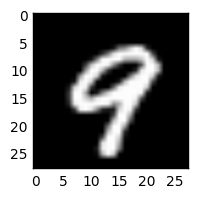

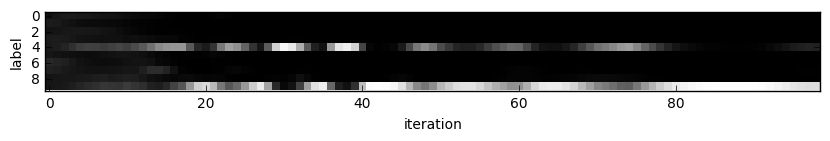

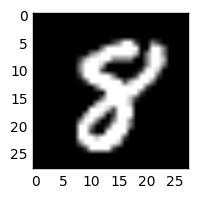

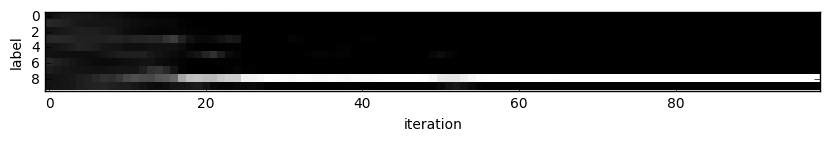

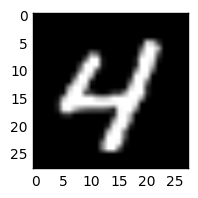

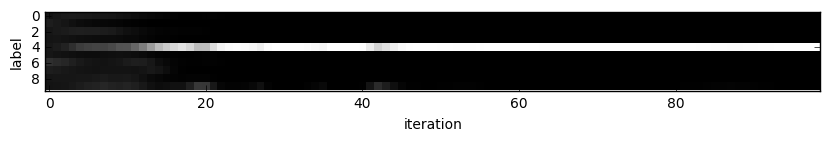

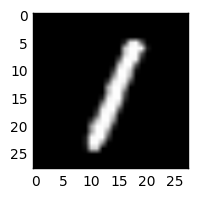

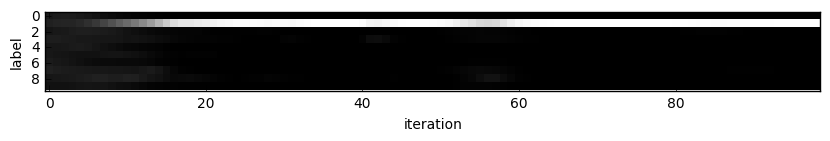

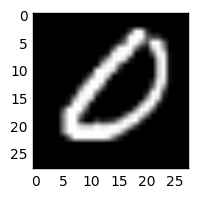

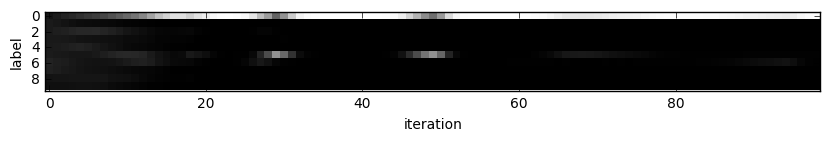

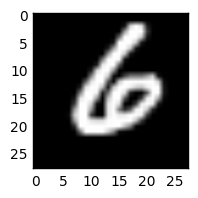

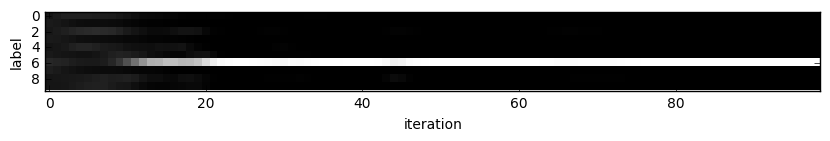

In [20]:
for i in range(8):
    plt.figure(figsize=(2, 2))
    plt.imshow(solver.test_nets[0].blobs['data'].data[i, 0], cmap='gray')
    plt.figure(figsize=(10, 2))
    plt.imshow(np.exp(output[:99, i].T) / np.exp(output[:99, i].T).sum(0), interpolation='nearest', cmap='gray')
    plt.xlabel('iteration')
    plt.ylabel('label')

*  Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.



(125, 125)


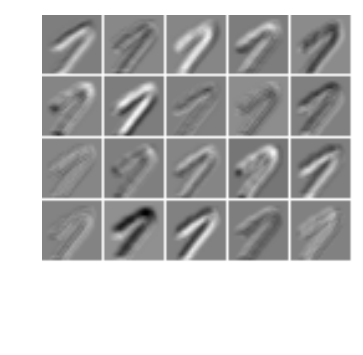

In [71]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    print data.shape
    plt.imshow(data, cmap=plt.cm.gray); plt.axis('off')
    
feat = solver.net.blobs['conv1'].data[63, :]
vis_square(feat)

(-0.5, 24.5, 19.5, -0.5)

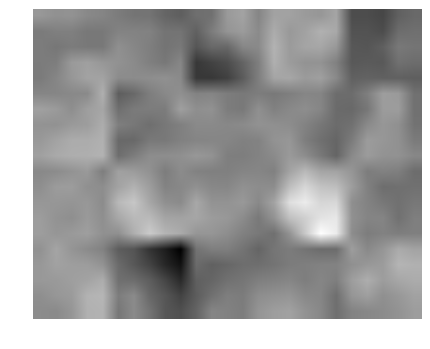

In [72]:
plt.imshow(solver.net.params['conv1'][0].diff[:, 0].reshape(4, 5, 5, 5)
       .transpose(0, 2, 1, 3).reshape(4*5, 5*5), cmap='gray'); plt.axis('off')

Problem 5
===

### Experiment with architecture and optimization

Now that we've defined, trained, and tested LeNet there are many possible next steps:

- Define new architectures for comparison
- Tune optimization by setting `base_lr` and the like or simply training longer
- Switching the solver type from `SGD` to an adaptive method like `AdaDelta` or `Adam`

Feel free to explore these directions by editing the all-in-one example that follows.
Look for "`EDIT HERE`" comments for suggested choice points.

By default this defines a simple linear classifier as a baseline.

In case your coffee hasn't kicked in and you'd like inspiration, try out

1. Switch the nonlinearity from `ReLU` to `ELU` or a saturing nonlinearity like `Sigmoid`
2. Stack more fully connected and nonlinear layers
3. Search over learning rate 10x at a time (trying `0.1` and `0.001`)
4. Switch the solver type to `Adam` (this adaptive solver type should be less sensitive to hyperparameters, but no guarantees...)
5. Solve for longer by setting `niter` higher (to 500 or 1,000 for instance) to better show training differences

Iteration 0 testing...
Iteration 25 testing...
Iteration 50 testing...
Iteration 75 testing...
Iteration 100 testing...
Iteration 125 testing...
Iteration 150 testing...
Iteration 175 testing...
Iteration 200 testing...
Iteration 225 testing...


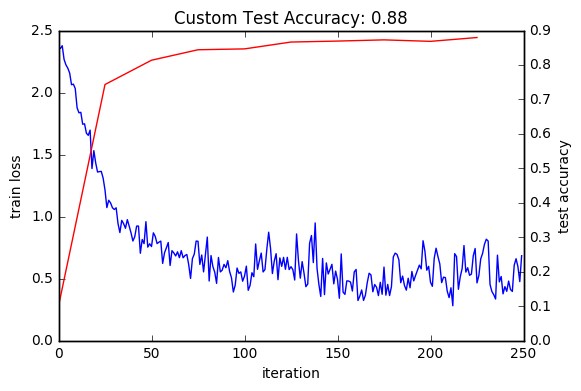

In [39]:
train_net_path = 'mnist/custom_auto_train.prototxt'
test_net_path = 'mnist/custom_auto_test.prototxt'
solver_config_path = 'mnist/custom_auto_solver.prototxt'

### define net
def custom_net(lmdb, batch_size):
    # define your own net!
    n = caffe.NetSpec()
    
    # keep this data layer for all networks
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    # EDIT HERE to try different networks
    # this single layer defines a simple linear classifier
    # (in particular this defines a multiway logistic regression)
    n.score =   L.InnerProduct(n.data, num_output=10, weight_filler=dict(type='xavier'))
    
    # EDIT HERE this is the LeNet variant we have already tried
    # n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    # n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    # n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    # n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    # EDIT HERE consider L.ELU or L.Sigmoid for the nonlinearity
    # EDIT HERE why not try a dropout? L.Dropout(n.??, dropout_ratio = ??, in_place=True)
    # n.relu1 = L.ReLU(n.fc1, in_place=True)
    # n.score =   L.InnerProduct(n.fc1, num_output=10, weight_filler=dict(type='xavier'))
    
    # keep this loss layer for all networks
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()

with open(train_net_path, 'w') as f:
    f.write(str(custom_net('mnist/data/mnist_train_lmdb', 64)))    
with open(test_net_path, 'w') as f:
    f.write(str(custom_net('mnist/data/mnist_test_lmdb', 100)))

### define solver
from caffe.proto import caffe_pb2
s = caffe_pb2.SolverParameter()

# Set a seed for reproducible experiments:
# this controls for randomization in training.
s.random_seed = 0xCAFFE

# Specify locations of the train and (maybe) test networks.
s.train_net = train_net_path
s.test_net.append(test_net_path)
s.test_interval = 500  # Test after every 500 training iterations.
s.test_iter.append(100) # Test on 100 batches each time we test.

s.max_iter = 10000     # no. of times to update the net (training iterations)
 
# EDIT HERE to try different solvers
# solver types include "SGD", "Adam", and "Nesterov" among others.
s.type = "SGD"

# Set the initial learning rate for SGD.
s.base_lr = 0.01  # EDIT HERE to try different learning rates
# Set momentum to accelerate learning by
# taking weighted average of current and previous updates.
s.momentum = 0.9
# Set weight decay to regularize and prevent overfitting
s.weight_decay = 5e-4

# Set `lr_policy` to define how the learning rate changes during training.
# This is the same policy as our default LeNet.
s.lr_policy = 'inv'
s.gamma = 0.0001
s.power = 0.75
# EDIT HERE to try the fixed rate (and compare with adaptive solvers)
# `fixed` is the simplest policy that keeps the learning rate constant.
# s.lr_policy = 'fixed'

# Display the current training loss and accuracy every 1000 iterations.
s.display = 1000

# Snapshots are files used to store networks we've trained.
# We'll snapshot every 5K iterations -- twice during training.
s.snapshot = 5000
s.snapshot_prefix = 'mnist/custom_net'

# Train on the GPU
s.solver_mode = caffe_pb2.SolverParameter.GPU

# Write the solver to a temporary file and return its filename.
with open(solver_config_path, 'w') as f:
    f.write(str(s))

### load the solver and create train and test nets
solver = None  # ignore this workaround for lmdb data (can't instantiate two solvers on the same data)
solver = caffe.get_solver(solver_config_path)

### solve
niter = 250  # EDIT HERE increase to train for longer
test_interval = niter / 10
# losses will also be stored in the log
train_loss = np.zeros(niter)
test_acc = np.zeros(int(np.ceil(niter / test_interval)))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['score'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1e4

_, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(np.arange(niter), train_loss)
ax2.plot(test_interval * np.arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Custom Test Accuracy: {:.2f}'.format(test_acc[-1]))